# **Entrega 4 - Aprendizaje de máquinas**

## **Ejercicio 1 - Clasificación (C = 2.5)**


Implemente un perceptrón simple para el problema de clasificación. Utilice los datos generados a partir de su número de CC. Luego de entrenar, calcule y muestre el accuracy y las fronteras de decisión.

In [15]:
#@markdown ------
#@markdown #### **⚠️ Ingrese su número de CC**. ⬇

!gdown -qq "https://drive.google.com/uc?id=1dhfmGJwJbbcH1XxI0yuJRgDiVRbEaZ3B" -O /eval_tools-1.5-py3-none-any.whl
!pip3 -qq install /eval_tools-1.5-py3-none-any.whl
!rm -r /eval_tools-1.5-py3-none-any.whl

import numpy as np
from eval_tools import import_bicluster_from_CC

CC = 1001470137 #@param {type:"number"}

train_data, test_data, train_targets, test_targets = import_bicluster_from_CC (CC, lucky_algo = np.random.randint(0,4))
#@markdown ------

In [16]:
print (train_data.shape, test_data.shape, train_targets.shape, test_targets.shape)

(1200, 2) (120, 2) (1200,) (120,)


In [17]:
import torch

import numpy as np
from matplotlib import pyplot as plt

In [18]:
#---- Introduzca su codigo aqui. Puede utilizar cuantas celdas de código considere necesarias
def activation(cond, x_1, x_2):
    return (cond * x_1) + (~(cond) * x_2)

class Perceptron():
    def __init__(self, num_features, learning_rate=0.1):
        self.num_features = num_features
        self.weights = torch.zeros( num_features , 1)
        self.bias = torch.zeros(1)
        self.learning_rate = learning_rate

    def forward(self, X ):
        linear = torch.add(torch.mm( X , self.weights ), self.bias )
        predictions = activation(linear > 0., 1, 0).float() # Step
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs = 100):
        for epoch in range( epochs ):
            for i in range(y.size()[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += self.learning_rate * (errors * x[i]).view(self.num_features, 1)
                self.bias += self.learning_rate + errors

    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

In [19]:
pps = Perceptron(num_features=2, learning_rate=0.001)

train_data_tensor = torch.from_numpy( train_data ).type(torch.FloatTensor)
train_targets_tensor = torch.from_numpy( train_targets ).type(torch.FloatTensor)

pps.train( train_data_tensor , train_targets_tensor , epochs=150)

In [20]:
test_data_tensor = torch.from_numpy( test_data ).type(torch.FloatTensor).to('cpu')
test_targets_tensor = torch.from_numpy( test_targets ).type(torch.FloatTensor).to('cpu')

test_acc = pps.evaluate( test_data_tensor , test_targets_tensor )
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 97.50%


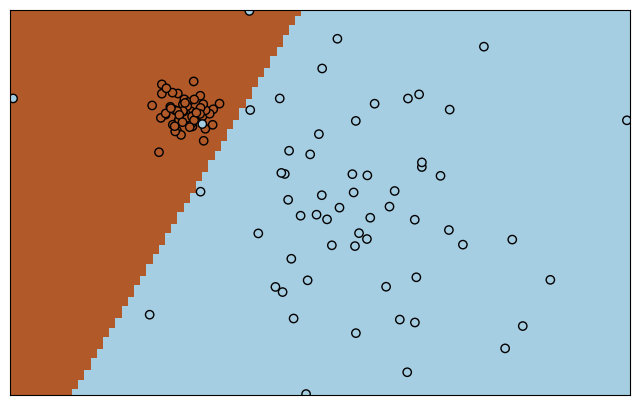

In [21]:
# Min max values for the decision bounding grid
h_min, h_max = test_data[:,0].min() , test_data[:,0].max()
v_min, v_max = test_data[:,1].min() , test_data[:,1].max()

# Create the grid
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 100), np.linspace( v_min , v_max , 200))

# Predict
to_predict = torch.from_numpy(np.c_[h_grid.ravel(), v_grid.ravel()]).type(torch.FloatTensor)
predictions = pps.forward( to_predict )
pred_grid = predictions.numpy().reshape(h_grid.shape)

# Draw everything
_, ax = plt.subplots (figsize=(8,5))
ax.pcolormesh( h_grid , v_grid , pred_grid , cmap = "Paired")

# show the scatter
ax.scatter (test_data[:,0] , test_data[:,1] ,  c = test_targets , edgecolors='k', cmap=plt.cm.Paired)

ax.set_xticks(())
ax.set_yticks(());

## **Ejercicio 2 - Regresión (C = 2.5)**


Implemente un perceptrón simple para el problema de regresión. Utilice los datos contenidos en la carpeta ```car_prices_data/```. Divida los datos en entrenamiento y pruebay y use todas las variables en el dataframe para entrenar (excepto aquellas que contengan texto). Luego de entrenar, calcule y muestre el ```MAE``` y ```MSE```. Compare las predicciones y los valores reales de prueba usando un diagrama de dispersión.

In [22]:
#@markdown ---------------
#@markdown ## **⚠️❗ Ejecute esta celda para descargar Cars Prices dataset❗⚠️**
#@markdown ### Esta celda creará la carpeta ```/content/car_prices_data```


!pip install -qq gdown
!gdown -qq "https://drive.google.com/uc?id=1SUHtRNMuY7UGxNA7Bklduir_Is3Ufm7f" -O /car_prices.zip
!mkdir /content/car_prices_data/
!unzip -qq /car_prices.zip -d /content/car_prices_data
!rm -r /car_prices.zip
#@markdown ---------------

mkdir: cannot create directory ‘/content/car_prices_data/’: File exists
replace /content/car_prices_data/car_prices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [23]:
!ls car_prices_data/

car_prices.csv


In [24]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [25]:
# Load the data
df = pd.read_csv('/content/car_prices_data/car_prices.csv')

# Clean the data
df_numeric = df.drop(columns=['car-house'])

df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

df_numeric = df_numeric.dropna()

X = df_numeric.drop(columns=['price'])
y = df_numeric['price']


In [26]:
class PerceptronRegression:
  def __init__(self, num_features, learning_rate=0.001):
    self.num_features = num_features
    self.weights = torch.zeros(num_features, 1)
    self.bias = torch.zeros(1)
    self.learning_rate = learning_rate

  def forward(self, X):
    return torch.add(torch.mm(X, self.weights), self.bias)

  def train(self, x, y, epochs=100, batch_size=32):
    losses = []

    for epoch in range(epochs):
      permutation = torch.randperm(x.size(0))
      for i in range(0, x.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        x_batch = x[indices]
        y_batch = y[indices]

        predictions = self.forward(x_batch)
        errors = predictions - y_batch

        grad_w = (2.0 / len(x_batch)) * torch.mm(x_batch.t(), errors)
        grad_b = (2.0 / len(x_batch)) * torch.sum(errors)

        self.weights -= self.learning_rate * grad_w
        self.bias -= self.learning_rate * grad_b

      loss = torch.mean(errors ** 2).item()
      losses.append(loss)

    return losses

  def evaluate(self, x, y):
    with torch.no_grad():
      predictions = self.forward(x).view(-1)
      mse = torch.mean((predictions - y) ** 2).item()
      mae = torch.mean(torch.abs(predictions - y)).item()
    return predictions, mse, mae


In [27]:
# Convert data to numpy arrays
X_np = X.to_numpy()
y_np = y.to_numpy().reshape(-1, 1)

# Split into training and test sets
train_data, test_data, train_targets, test_targets = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# Scale features
X_train_scaled = (train_data - train_data.mean()) / train_data.std()
X_test_scaled = (test_data - train_data.mean()) / train_data.std()

# Scale the target variable
y_train_scaled = (train_targets - train_targets.mean()) / train_targets.std()
y_test_scaled = (test_targets - train_targets.mean()) / train_targets.std()

# Scale the Indexes
indexes = np.arange(len(y_test_scaled))
indexes_scaled = (indexes - indexes.mean()) / indexes.std()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


Test MAE: 1.1564
Test MSE: 2.6497


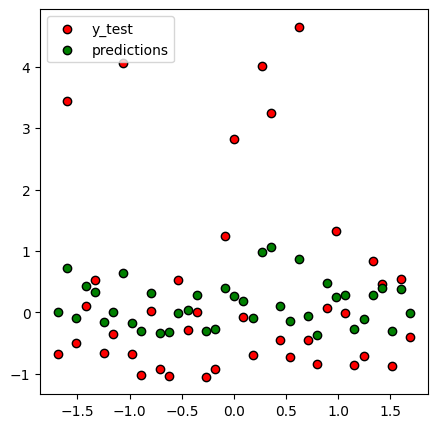

In [28]:
# Create and train the model
model = PerceptronRegression(num_features=train_data.shape[1], learning_rate=0.001)
losses = model.train(X_train_tensor, y_train_tensor, epochs=500, batch_size=32)

# Evaluate the model
predictions_scaled, mse, mae = model.evaluate(X_test_tensor, y_test_tensor)

# Show the MAE and MSE
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")

# Draw everything
_, ax = plt.subplots(figsize=(5, 5))

# show the scatter
ax.scatter(indexes_scaled, y_test_scaled, c='r', edgecolors='k', label='y_test')
ax.scatter(indexes_scaled, predictions_scaled, c='g', edgecolors='k', label='predictions')
plt.legend(loc='upper left');
